## Projeto Final - Detector de Fake News
#### Aprendizado Profundo Para Processamento de Linguagem Natural

**Aluno**: Bernardo Gomes Nunes<br>
**Matrícula**: 2019054374

### 1. Importando base de dados e dependências

As bibliotecas utilizadas nesse projeto foram:

- **Pandas**: utilizada para leitura e manipulação da base de dados

- **PyTorch**: biblioteca de deep learning usada para construir e treinar modelos de rede neural. Muitos modelos pré-treinados, inclusive o BERT, estão disponíveis nela.

- **Transformers**: oferece uma grande variedade de modelos pré-treinados, incluindo o BERT, em diversos idiomas.

- **Scikit-learn**: utilizada na etapa de avaliação do modelo para calcular acurácia, precisão, recall e F1 score.

- **Matplotlib**: utilizado para criar plots a partir das métricas de avaliação.

#### Sobre o corpus

Utilizei o corpus [Fake.br](https://github.com/roneysco/Fake.br-Corpus/tree/master) para treinamento do modelo. Ele possui cerca de 3600 pares de notícias: uma falsa e outra verdadeira. Vale ressaltar que são todas em português. Cada linha do *dataset* contém o texto da notícia pré-processado e uma *label* indicando se é a notícia é verdadeira ou falsa.

In [1]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/roneysco/Fake.br-Corpus/master/preprocessed/pre-processed.csv')
df.head()

,index,label,preprocessed_news
0,0,fake,katia abreu diz vai colocar expulsao moldura n...
1,1,fake,ray peita bolsonaro conservador fake entrevist...
2,2,fake,reinaldo azevedo desmascarado policia federal ...
3,3,fake,relatorio assustador bndes mostra dinheiro pub...
4,4,fake,radialista americano fala sobre pt vendem ilus...


In [2]:
df.groupby('label').count()

,index,preprocessed_news
label,,
fake,3600,3600
true,3600,3600


### 2. Pré-processamento

O próprio Fake.br já oferece uma versão pré-processada, que consiste em um `.csv` com o texto de cada notícia e a classificação. Nesse arquivo, os próprios mantedores do corpus normalizaram o texto removendo *stopwords*, acentuação e caracteres especiais. Também transformaram os textos para *lowercase*.

Como vamos utilizar um modelo BERT pré-treinado, já farei a tokenização de todas as notícias:

In [4]:
from transformers import BertTokenizer
import torch

# Carrega o tokenizador do BERT
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

# Guarda os IDs de entrada tokenizados para cada notícia
input_ids = []

# Guarda as máscaras de attention de cada notícia para distinguir tokens reais de preenchimento
attention_masks = []

for news in df['preprocessed_news']:

    tokens = tokenizer.encode_plus(
        news,
        max_length=512,
        truncation=True,
        padding='max_length',
    )

    input_ids.append(tokens['input_ids'])
    attention_masks.append(tokens['attention_mask'])

# Cria identificadores numéricos para as categorias possíveis
# 1 = fake, 0 = true
label_ids = torch.tensor((df['label'] == 'fake').astype(int).tolist())

print("Input IDs:", len(input_ids), input_ids[0])
print("Máscaras de Attention:", len(attention_masks), attention_masks[0])
print("Label IDs:", len(label_ids), label_ids)


Input IDs: 7200 [101, 1396, 352, 151, 7674, 22288, 1331, 2541, 7201, 11407, 13793, 3848, 9217, 229, 22280, 15158, 22282, 7347, 22278, 1396, 352, 151, 7674, 22288, 1996, 11407, 13793, 126, 22287, 22284, 22295, 2453, 1334, 22280, 1034, 11312, 2233, 17882, 995, 4272, 384, 22032, 252, 17891, 11967, 159, 3848, 9217, 18458, 11407, 13793, 2113, 223, 128, 582, 3429, 2684, 8849, 243, 3264, 13756, 1273, 1653, 452, 1101, 11407, 490, 229, 22280, 13933, 2639, 13933, 2639, 14312, 128, 2004, 128, 1996, 1396, 352, 151, 7674, 22288, 169, 22279, 11407, 13793, 3233, 316, 22280, 4062, 1273, 1653, 452, 19020, 5334, 8008, 364, 1396, 352, 151, 4178, 793, 5607, 3554, 1396, 352, 151, 229, 22280, 2261, 126, 22286, 3243, 1941, 4360, 6618, 857, 4048, 126, 22286, 14971, 1396, 352, 151, 2529, 1968, 22281, 236, 318, 1471, 2041, 364, 285, 1839, 126, 22287, 22284, 22295, 10468, 159, 3547, 2226, 1396, 352, 151, 4412, 5334, 2537, 13779, 2148, 1557, 944, 18694, 596, 2684, 2182, 126, 22286, 229, 22280, 22150, 4250, 1396, 

### 3. Análise Exploratória

In [4]:
df_t = df[df['label'] == 'true']
df_f = df[df['label'] == 'fake']

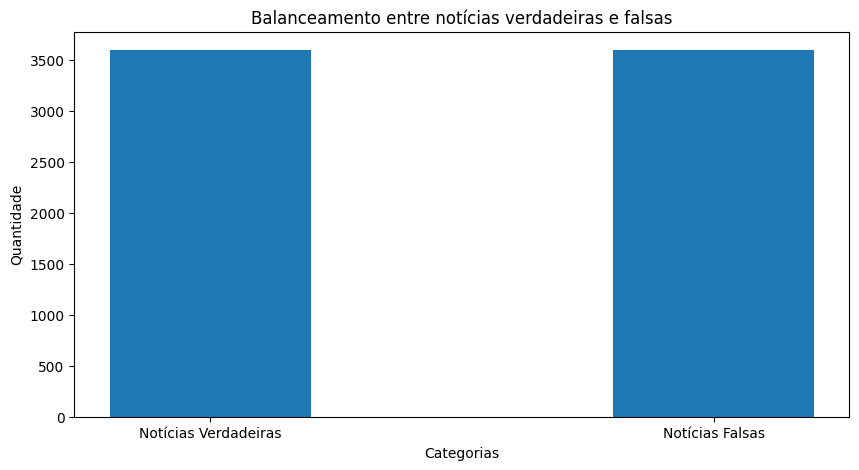

In [5]:
import matplotlib.pyplot as plt 
 
fig = plt.figure(figsize = (10, 5))
 
plt.bar(['Notícias Verdadeiras', 'Notícias Falsas'], [len(df_t), len(df_f)], width = 0.4)
 
plt.xlabel("Categorias")
plt.ylabel("Quantidade")
plt.title("Balanceamento entre notícias verdadeiras e falsas")
plt.show()


In [6]:
df_t['length'] = df_t['preprocessed_news'].str.len()
df_f['length'] = df_f['preprocessed_news'].str.len()

/var/folders/06/r2kd06zs0234wgqy1f2qf__00000gn/T/ipykernel_2942/851675523.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['length'] = df_t['preprocessed_news'].str.len()
/var/folders/06/r2kd06zs0234wgqy1f2qf__00000gn/T/ipykernel_2942/851675523.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_f['length'] = df_f['preprocessed_news'].str.len()


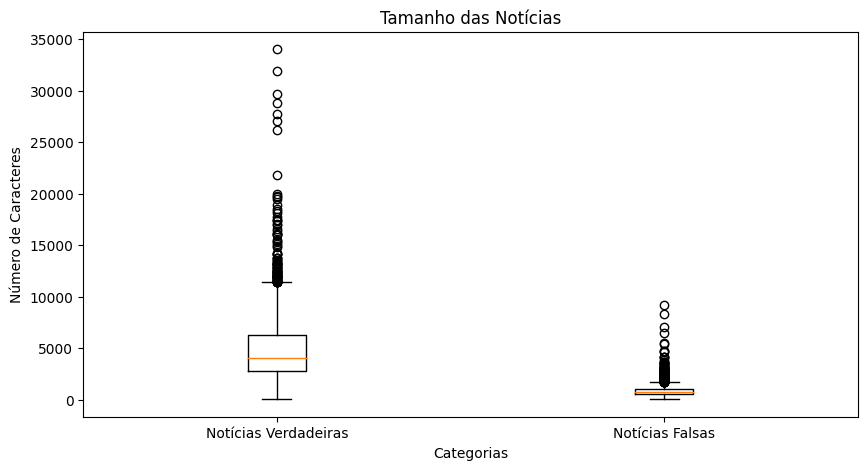

In [7]:
fig = plt.figure(figsize = (10, 5))
 
plt.boxplot([df_t['length'], df_f['length']])
plt.xticks([1, 2], ['Notícias Verdadeiras', 'Notícias Falsas'])
 
plt.xlabel("Categorias")
plt.ylabel("Número de Caracteres")
plt.title("Tamanho das Notícias")
plt.show()

In [8]:
from collections import Counter


def count_word_frequency(column):
    all_text = ' '.join(column)
    words = all_text.split()    
    word_counts = Counter(words)
    
    return word_counts

# Conta a frequência de palavras em cada classe
true_word_freq = count_word_frequency(df_t['preprocessed_news'])
fake_word_freq = count_word_frequency(df_f['preprocessed_news'])


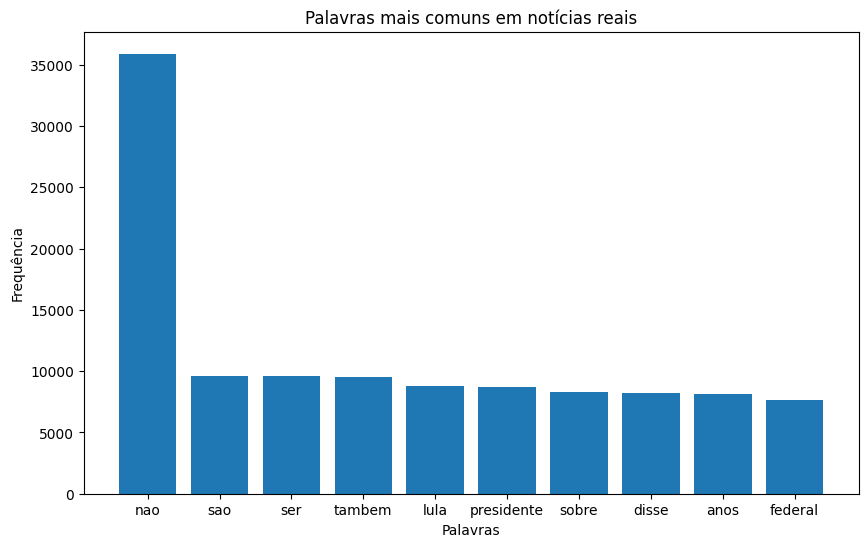

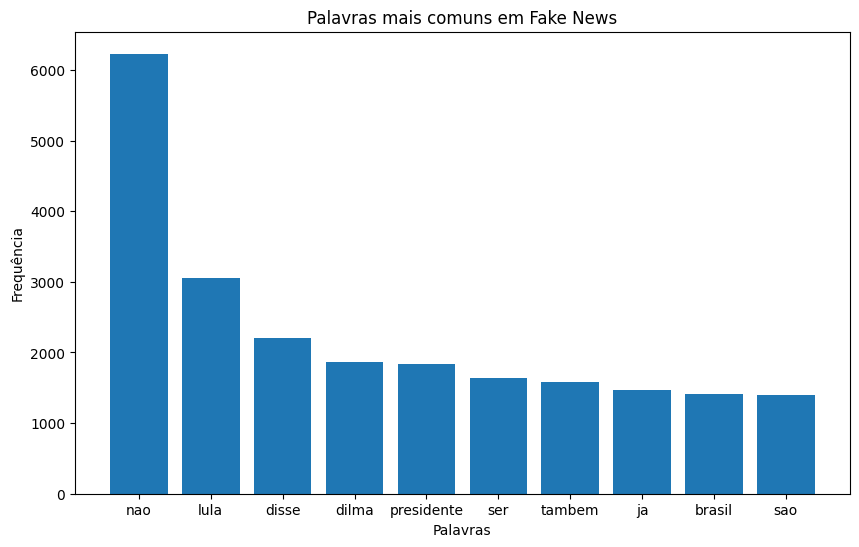

In [9]:
def plot_word_frequencies(word_freq, title, num_words=10):
    common_words = dict(word_freq.most_common(num_words))
    plt.figure(figsize=(10, 6))
    plt.bar(common_words.keys(), common_words.values())
    plt.title(title)
    plt.xlabel('Palavras')
    plt.ylabel('Frequência')
    plt.show()

plot_word_frequencies(true_word_freq, 'Palavras mais comuns em notícias reais')
plot_word_frequencies(fake_word_freq, 'Palavras mais comuns em Fake News')


### 4. Treinando o modelo



In [11]:
from sklearn.model_selection import StratifiedKFold

# Validação Cruzada
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=100)


In [24]:
from transformers import BertForSequenceClassification, AdamW
from tqdm import tqdm

def train(train_loader, device):
    # Carrega modelo BERT model para classificação
    model = BertForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased', num_labels=2)
    optimizer = AdamW(model.parameters(), lr=2e-5)

    # Training loop
    epochs = 3
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_losses = []

        for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}'):
            inputs, attention_mask, labels = batch
            inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            train_losses.append(loss.item())

            loss.backward()
            optimizer.step()

        average_train_loss = sum(train_losses) / len(train_losses)
        print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {average_train_loss:.4f}')

    return model


In [25]:
def test(model, test_loader, device):
    model.eval()
    test_predictions = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Evaluating'):
            inputs, attention_mask, labels = batch
            inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(inputs, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits

            predictions = torch.argmax(logits, dim=1).cpu().numpy()
            test_predictions.extend(predictions)

    return test_predictions


In [26]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import os


fold_results = []

# Treinando e avaliando modelo em cada partição
for fold, (train_index, test_index) in enumerate(skf.split(input_ids, label_ids)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Divide os conjuntos de treino e teste
    train_data, test_data = [input_ids[i] for i in train_index], [input_ids[i] for i in test_index]
    train_labels, test_labels = [label_ids[i] for i in train_index], [label_ids[i] for i in test_index]
    train_attention_masks, test_attention_masks = [attention_masks[i] for i in train_index], [attention_masks[i] for i in test_index]

    # Cria DataLoaders para treino e teste
    train_dataset = TensorDataset(torch.tensor(train_data), torch.tensor(train_attention_masks), torch.tensor(train_labels))
    test_dataset = TensorDataset(torch.tensor(test_data), torch.tensor(test_attention_masks), torch.tensor(test_labels))
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Treina o modelo
    if os.path.exists(f"./fine-tuned-model-{fold+1}"):
        model = BertForSequenceClassification.from_pretrained(f"./fine-tuned-model-{fold+1}")
    else:
        model = train(train_loader, device)

    # Faz predicoes de teste
    predictions = test(model, test_loader, device)

    # Guarda os resultados para analise posterior
    fold_results.append((torch.tensor(test_labels).cpu().numpy(), predictions))

    accuracy = accuracy_score(torch.tensor(test_labels).cpu().numpy(), predictions)
    print(f'Accuracy on the test set: {accuracy:.4f}')

    # Salva modelo
    model.save_pretrained(f"./fine-tuned-model-{fold+1}")



Fold 1/5


Evaluating: 100%|██████████| 180/180 [03:22<00:00,  1.13s/it]


Accuracy on the test set: 0.9861
Fold 2/5


Evaluating: 100%|██████████| 180/180 [03:23<00:00,  1.13s/it]


Accuracy on the test set: 0.9819
Fold 3/5


Evaluating: 100%|██████████| 180/180 [03:25<00:00,  1.14s/it]

Accuracy on the test set: 0.9729
Fold 4/5
Fold 5/5


### 5. Avaliação


#### 5.1 - Acurácia, precisão e recall

In [31]:
true_labels, predicted_labels = fold_results[1]

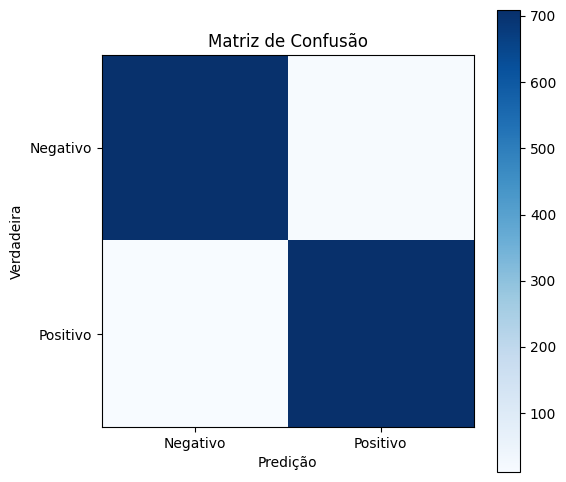

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix



cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()
plt.xlabel('Predição')
plt.ylabel('Verdadeira')
plt.xticks([0, 1], ['Negativo', 'Positivo'])
plt.yticks([0, 1], ['Negativo', 'Positivo'])
plt.show()

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np

accuracies = []
precisions = []
recalls = []

for true_labels, predicted_labels in fold_results:
    accuracies.append(accuracy_score(true_labels, predicted_labels))
    precisions.append(precision_score(true_labels, predicted_labels))
    recalls.append(recall_score(true_labels, predicted_labels))

accuracy, precision, recall = np.mean(accuracies), np.mean(precisions), np.mean(recalls)

In [35]:
print('Acurácia: ', accuracy)
print('Precisão: ', precision)
print('Recall: ', recall)

Acurácia:  0.9803240740740741
Precisão:  0.9855436072539391
Recall:  0.975


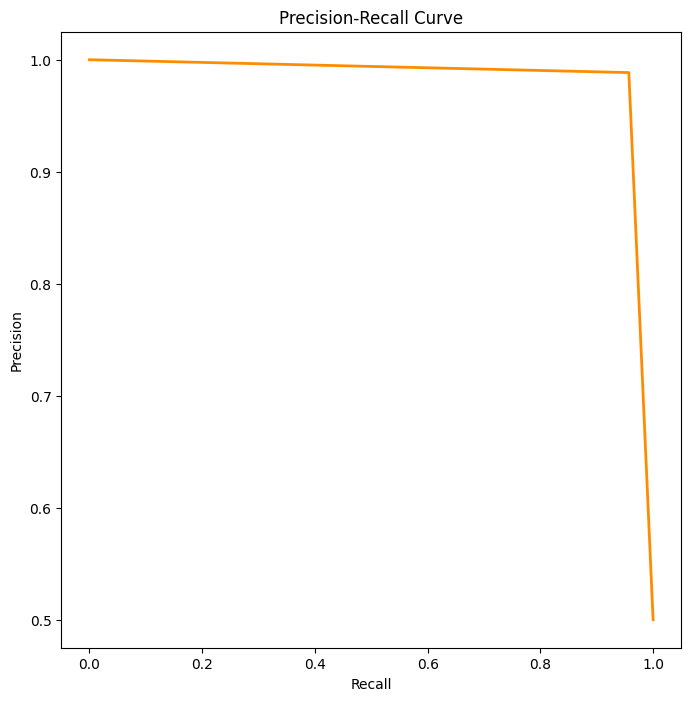

In [36]:

from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(true_labels, predicted_labels)
plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

#### 5.2 - F1 Score

In [37]:
from sklearn.metrics import f1_score

scores = []

for true_labels, predicted_labels in fold_results:
    scores.append(f1_score(true_labels, predicted_labels))

print('F1 Score: ', np.mean(scores))

F1 Score:  0.9801813158174357


#### 5.3 - ROC e AUC


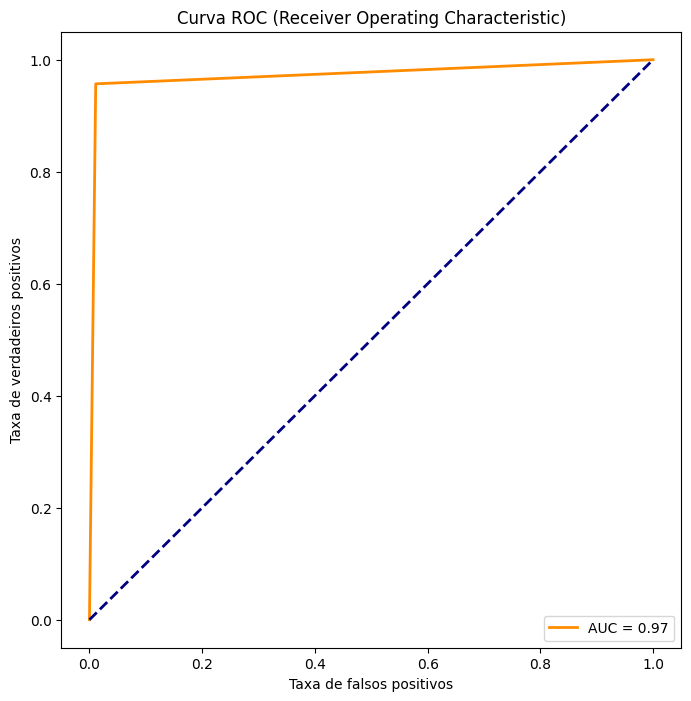

In [40]:

from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)
roc_auc = roc_auc_score(true_labels, predicted_labels)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taxa de falsos positivos')
plt.ylabel('Taxa de verdadeiros positivos')
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.legend(loc='lower right')
plt.show()
